# IF evluation beased on Inforbench

In [29]:
import pandas as pd
import time
from openai import OpenAI
from tqdm import tqdm
import os

# Read data using
SYS_MSG = "Based on the provided Input (if any) and Generated Text, answer the ensuing Questions with either a YES or NO choice. Your selection should be based on your judgment as well as the following rules:\n\n- YES: Select 'YES' if the generated text entirely fulfills the condition specified in the question. However, note that even minor inaccuracies exclude the text from receiving a 'YES' rating. As an illustration. consider a question that asks. \"Does each sentence in the generated text use a second person?” If even one sentence does not use the second person, the answer should NOT be 'YES'. To qualify for a 'YES' rating, the generated text must be entirely accurate and relevant to the question\n\n- NO: Opt for 'NO' if the generated text fails to meet the question's requirements or provides no information that could be utilized to answer the question. For instance, if the question asks. \"Is the second sentence in the generated text a compound sentence?\" and the generated text only has one sentence. it offers no relevant information to answer the question. Consequently, the answer should be 'NO'.'''"

foler_path = "Paper Experiment Results/New_filtered/IF"
file_name = "supplementary_IF.csv"
output_file_name = file_name.replace(".csv", "_evaluated.csv")
input_path = os.path.join(foler_path, file_name)
output_path = os.path.join(foler_path, output_file_name)
_data = pd.read_csv(input_path)
eval_model = "gpt-3.5-turbo-0125"
api_key = os.getenv("OPENAI_API_KEY")
# api_key = "sk-proj-SO2y3QIaRpeWkRIkYRAiT3BlbkFJj6A62UbQlaJSGpmSiIFN"
client = OpenAI(api_key=api_key)
temperature = 0

FileNotFoundError: [Errno 2] No such file or directory: 'Paper Experiment Results/New_filtered/IF/supplementary_IF.csv'

In [ ]:
def extract_final_response(response, prompt):
    return response[len(prompt) :]


def match_prompt_column(model):
    if "Llama-2" in model:
        return "llama2_chat_initial_prompt"
    elif "Mixtral" in model or "Mistral" in model:
        return "mixtral_instruct_initial_prompt"
    elif "Llama-3" in model:
        return "llama3_chat_initial_prompt"
    else:
        print("The model name didn't match anything, please check!!!!")
        return None


def extract_pure_response(row):
    model = row["model"]
    prompt_column = match_prompt_column(model)
    response = row["generated_response"]
    prompt = row[prompt_column]
    return extract_final_response(response=response, prompt=prompt)


def process_string(input_string):
    processed_string = input_string.strip("[]").replace("\\", "")
    questions = processed_string.split("\n")
    questions = [q.strip("'") for q in questions]
    return questions


_data["pure_response"] = _data.apply(extract_pure_response, axis=1)

In [ ]:
import os

if os.path.exists(output_path):
    data_evaluated = pd.read_csv(output_path)
    last_idx = data_evaluated.shape[0]
else:
    last_idx = 0

In [ ]:
test_times = 0
times = 0
pbar = tqdm(total=len(_data))
for index, entry in tqdm(_data.iterrows()):
    if index <= last_idx:
        pbar.update(1)
        continue
    updated_row = entry.copy()
    input_task = entry["input"]
    output = entry["pure_response"]
    if output is None:  # skip if result hasn't been generated
        continue
    message = []
    answer = ""
    for question in process_string(entry["decomposed_questions"]):
        if len(message) == 0:
            if input_task:
                content = f'{SYS_MSG}\n\nInput:\n"{input_task}"\n\nGenerated Text:\n"{output}"\n\nQuestion:\n{question}\n'
            else:
                content = f'{SYS_MSG}\n\nGenerated Text:\n"{output}"\n\nQuestion:\n{question}\n'
        else:
            content = f"{question}\n"
        # print(content)
        message.append({"role": "user", "content": content})
        # create a chat completion
        success = False
        early_stop = False
        rep = 0
        while not success:
            if rep > 2:
                break
            try:
                completion = client.chat.completions.create(
                    model=eval_model,
                    messages=message,
                    temperature=temperature,
                )
                generation = completion.choices[0].message.content
                message.append({"role": "assistant", "content": generation})
                rep += 1
                # check if generation is yes or no
                if generation.lower().startswith(
                    "yes"
                ) or generation.lower().startswith("no"):
                    if generation.lower().startswith("yes"):
                        answer += "Yes\n"
                    else:
                        answer += "No\n"
                else:
                    if "YES" in generation and "NO" not in generation:
                        answer += "Yes\n"
                    elif "YES" not in generation and "NO" in generation:
                        answer += "No\n"
                    else:
                        for msg in message:
                            print(msg["content"])
                        print("NO YES or NO answer!" + generation)
                        answer += "None\n"
                        early_stop = True
                        break
                success = True
            except Exception as e:
                rep += 1
                print("ERROR!")
                print(e)
                print("Retry!")
                time.sleep(3)

        # when no answer occurs, break the loop and continue to next instance
        if early_stop:
            break

    answer = answer[:-1]
    # save eval results as List[bool]
    bool_results = []
    for i in answer.split("\n"):
        if i == "Yes":
            bool_results.append(True)
        elif i == "No":
            bool_results.append(False)
        else:
            bool_results.append(None)

    updated_row["eval"] = bool_results
    updated_row["messages_openai"] = message
    test_times += 1
    updated_dataframe = pd.DataFrame([updated_row])
    pbar.update(1)
    if not os.path.exists(output_path):
        updated_dataframe.to_csv(output_path, index=False, mode="w", header=True)
    else:
        updated_dataframe.to_csv(output_path, index=False, mode="a", header=False)
    times = times + 1

# Test On one single dataset

In [ ]:
import pandas as pd

df = pd.read_csv(
    "/home/lujun/local/temperature_eval/Paper Experiment Results/New_filtered/IF/exp_result_Meta-Llama-3-8B-Instruct_20240503202231_evaluated.csv"
)

In [ ]:
df = df[~df["eval"].str.contains("None", na=False)]


def count_true_false(string):
    string_lower = string.lower()
    count_true = string_lower.count("true")
    count_false = string_lower.count("false")
    return count_true, count_false


df[["true_count", "false_count"]] = df["eval"].apply(count_true_false).apply(pd.Series)
df["DRFR"] = df["true_count"] / (df["true_count"] + df["false_count"])

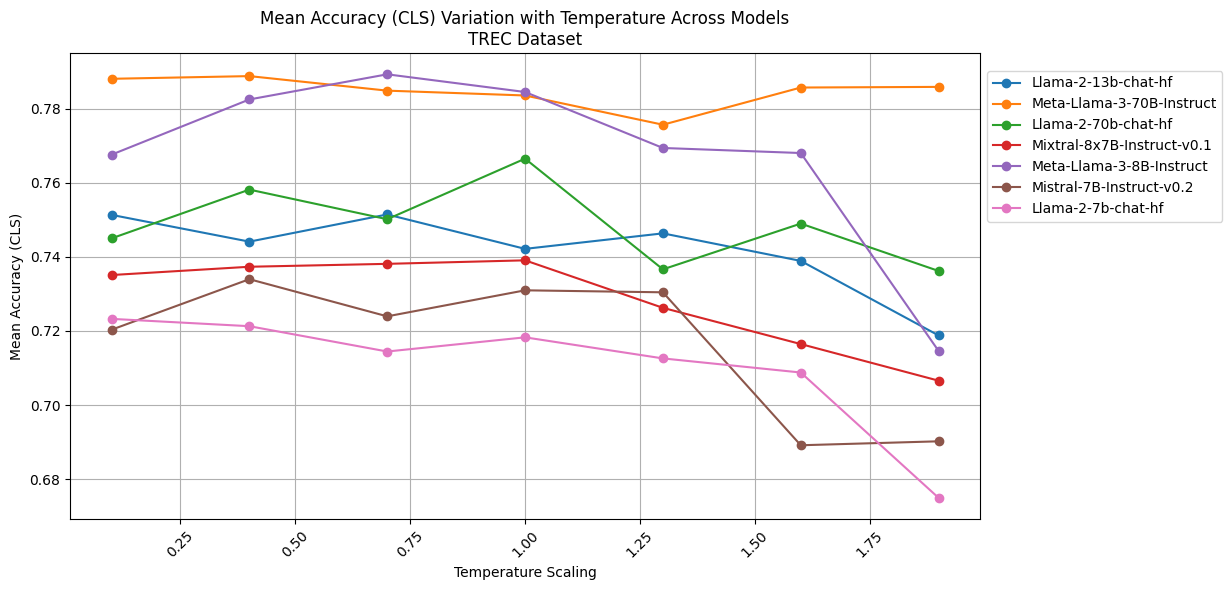

In [ ]:
import matplotlib.pyplot as plt

grouped_data = df.groupby(["model", "Temperature"])["DRFR"].mean()

models = df["model"].unique()

plt.figure(figsize=(10, 6))
for model in models:
    model_data = grouped_data[model]
    plt.plot(
        model_data.index.get_level_values("Temperature"),
        model_data,
        marker="o",
        label=model,
    )

plt.xlabel("Temperature Scaling")
plt.ylabel("Mean Accuracy (CLS)")
plt.title("Mean Accuracy (CLS) Variation with Temperature Across Models\nTREC Dataset")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.legend(loc="center left", bbox_to_anchor=(1, 0.8))

plt.show()

# Test On all Models

In [1]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt

current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")
output_photo_name = f"IF_{current_time_str}.svg"
model_weight_sizes = {
    "Llama-2-13b-chat-hf": 13,
    "Mistral-7B-Instruct-v0.2": 7,
    "Llama-2-70b-chat-hf": 70,
    "Meta-Llama-3-8B-Instruct": 8,
    "Llama-2-7b-chat-hf": 7,
    "Mixtral-8x7B-Instruct-v0.1": 56,
}

model_map = {
    "Llama-2-7b-chat-hf": 0,
    "Llama-2-13b-chat-hf": 1,
    "Llama-2-70b-chat-hf": 2,
    "Meta-Llama-3-8B-Instruct": 3,
    "Meta-Llama-3-70B-Instruct": 4,
    "Mistral-7B-Instruct-v0.2": 5,
    "Mixtral-8x7B-Instruct-v0.1": 6,
}

marker_map = {
    "Llama-2-7b-chat-hf": ".",
    "Llama-2-13b-chat-hf": "*",
    "Llama-2-70b-chat-hf": "o",
    "Meta-Llama-3-8B-Instruct": "+",
    "Meta-Llama-3-70B-Instruct": "^",
    "Mistral-7B-Instruct-v0.2": "<",
    "Mixtral-8x7B-Instruct-v0.1": ">",
}

color_map = {
    "Llama-2-7b-chat-hf": "C0",
    "Llama-2-13b-chat-hf": "C1",
    "Llama-2-70b-chat-hf": "C2",
    "Meta-Llama-3-8B-Instruct": "C3",
    "Meta-Llama-3-70B-Instruct": "C4",
    "Mistral-7B-Instruct-v0.2": "C5",
    "Mixtral-8x7B-Instruct-v0.1": "C6",
}

folder_path = "Paper Experiment Results/New_filtered/IF"
output_photo_name = f"IF_{current_time_str}.svg"
output_photo_path = os.path.join(folder_path, output_photo_name)
all_dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "evaluated" in filename:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        df["weight_size"] = model_weight_sizes.get(model_name, None)
        all_dfs.append(df)

df = pd.concat(all_dfs, ignore_index=True)
df["model_encoded"] = df["model_name"].map(model_map)
df["Temperature"] = df["Temperature"].astype(float).round(1)
df = df[~df["eval"].str.contains("None", na=False)]


def count_true_false(string):
    string_lower = string.lower()
    count_true = string_lower.count("true")
    count_false = string_lower.count("false")
    return count_true, count_false


df[["true_count", "false_count"]] = df["eval"].apply(count_true_false).apply(pd.Series)
df["DRFR"] = df["true_count"] / (df["true_count"] + df["false_count"])

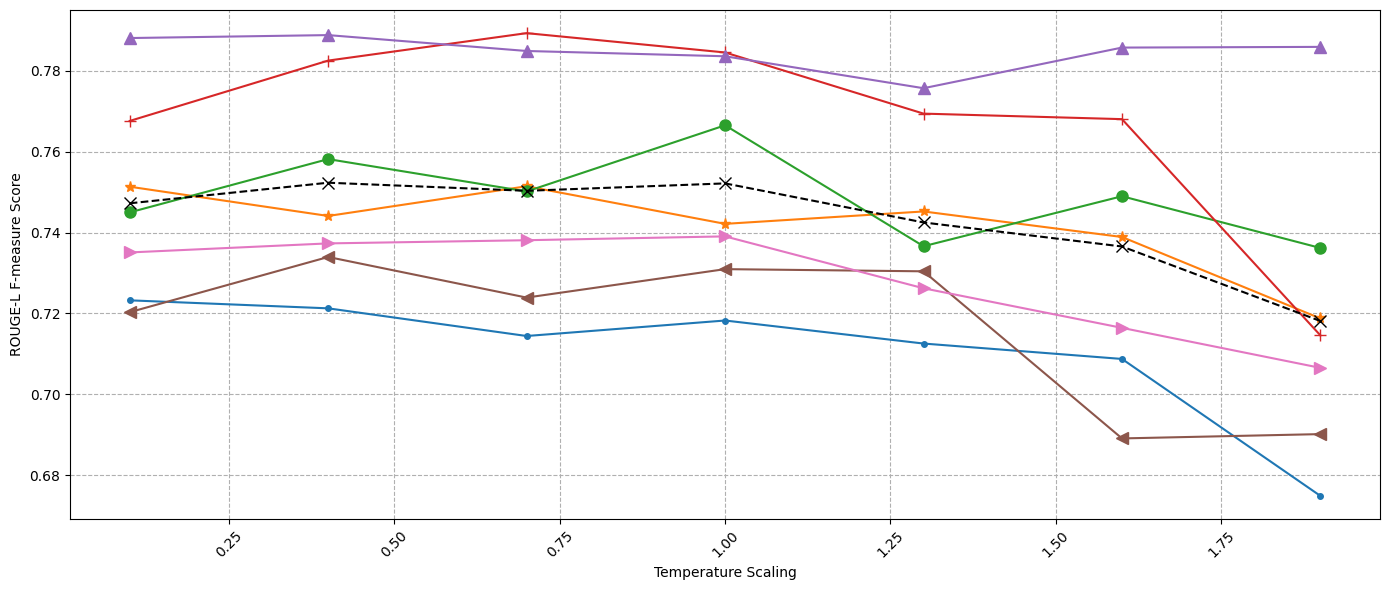

In [2]:
grouped_data = df.groupby(["model", "Temperature"])["DRFR"].mean()

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

markers = [
    ".",
    "*",
    "o",
    "+",
    "^",
    "<",
    ">",
    "8",
    "s",
    "p",
    ",",
    "v",
    "D",
    "d",
    "x",
    "|",
    "_",
]

plt.figure(figsize=(14, 6))
for i, model in enumerate(models):
    model_data = grouped_data[model]
    marker = markers[i % len(markers)]  # Select marker cyclically from the list
    plt.plot(
        model_data.index.get_level_values("Temperature"),
        model_data,
        marker=marker,
        markersize=8,
        label=model,
    )

grouped_data_temperature = df.groupby(["Temperature"])["DRFR"].mean()
plt.plot(
    grouped_data_temperature.index,
    grouped_data_temperature,
    linestyle="--",
    marker="x",
    markersize=8,
    color="black",
    label="Average Score Among All Models",
)

plt.xlabel("Temperature Scaling")
plt.ylabel("ROUGE-L F-measure Score")
# plt.title("Summarization\n Mean ROUGE-L F-measure with Temperature Across Models")
plt.grid(
    linestyle="--",
)
plt.xticks(rotation=45)
plt.tight_layout()

# plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.savefig(output_photo_path, format="svg", bbox_inches="tight")
# plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

# Causal Estimation

In [18]:
import pandas as pd
import os
import datetime
import numpy as np
import warnings
from dowhy import CausalModel
from sklearn.linear_model import LinearRegression

# Data Preprocessing
warnings.filterwarnings("ignore")
current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")

folder_path = "Paper Experiment Results/New_filtered/IF"
output_photo_name = f"IF_{current_time_str}.svg"
output_photo_path = os.path.join(folder_path, output_photo_name)
df["pure_response"] = df["pure_response"].astype(str)
df["pure_response_length"] = df["pure_response"].apply(len)
df["time_per_char"] = df["elapsed_time"] / df["pure_response_length"]
df["initial_prompt_length"] = df["initial_prompt"].apply(len)
df["Temperature"] = df["Temperature"].round(1)
df["model_encoded"] = df["model_name"].map(model_map)
node_labels = [
    "Temperature",
    "model_encoded",
    "initial_prompt_length",
    "DRFR",
    "time_per_char",
]

causal_dataset_df = df[node_labels]

grouped = causal_dataset_df.groupby(["model_encoded", "Temperature"])

train_set = pd.DataFrame()
validation_set = pd.DataFrame()
for name, group in grouped:
    split_index = int(len(group) * 0.8)
    train = group.iloc[:split_index]
    validation = group.iloc[split_index:]
    train_set = pd.concat([train_set, train])
    validation_set = pd.concat([validation_set, validation])

# Temperature Scaling
start = 0.1
stop = 2.1
step = 0.3
control_values = np.arange(start, stop, step)

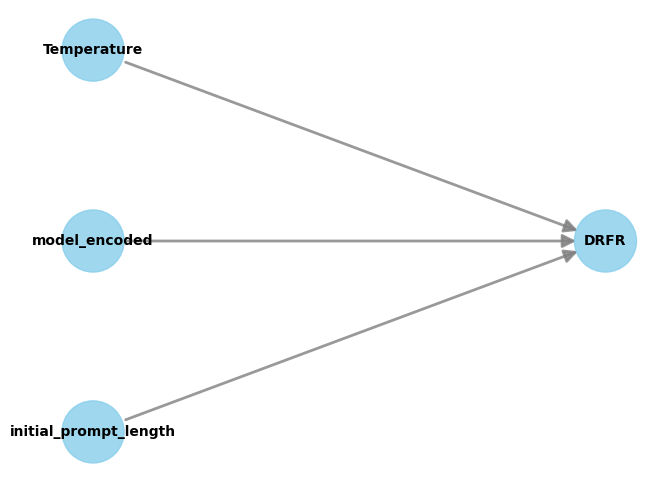

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                
──────────────(E[DRFR])
d[Temperature]         
Estimand assumption 1, Unconfoundedness: If U→{Temperature} and U→DRFR then P(DRFR|Temperature,,U) = P(DRFR|Temperature,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [19]:
model = CausalModel(
    data=causal_dataset_df,
    treatment=["Temperature"],
    outcome=["DRFR"],
    effect_modifiers=["model_encoded", "initial_prompt_length"],
)
model.view_model()

identified_estimand = model.identify_effect()
print(identified_estimand)

model_y = LinearRegression(fit_intercept=True)
model_t = LinearRegression(fit_intercept=True)

result_df = pd.DataFrame()
model_list = causal_dataset_df["model_encoded"].unique().tolist()
for control_value in control_values:
    dml_estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.econml.dml.LinearDML",
        confidence_intervals=True,
        control_value=control_value,
        treatment_value=control_value + step,
        method_params={
            "init_params": {
                "model_y": model_y,
                "model_t": model_t,
            }
        },
        fit_estimator=True,
    )
    for model_encoded in model_list:
        dml_estimate = model.estimate_effect(
            identified_estimand,
            method_name="backdoor.econml.dml.LinearDML",
            target_units=causal_dataset_df[
                causal_dataset_df["model_encoded"] == model_encoded
            ],
            confidence_intervals=True,
            control_value=control_value,
            treatment_value=control_value + step,
            method_params={
                "init_params": {
                    "model_y": model_y,
                    "model_t": model_t,
                }
            },
            fit_estimator=False,
        )
        estimate_value = dml_estimate.cate_estimates[0]
        lower_bound = dml_estimate.get_confidence_intervals()[:, :, 0][0][0]
        upper_bound = dml_estimate.get_confidence_intervals()[:, :, 0][1][0]
        data = {
            "lower_bound": lower_bound,
            "upper_bound": upper_bound,
            "estimate_value": estimate_value,
            "control_value": control_value,
            "model_encoded": model_encoded,
        }
        data_df = pd.DataFrame(data)
        result_df = pd.concat([result_df, data_df], ignore_index=True)

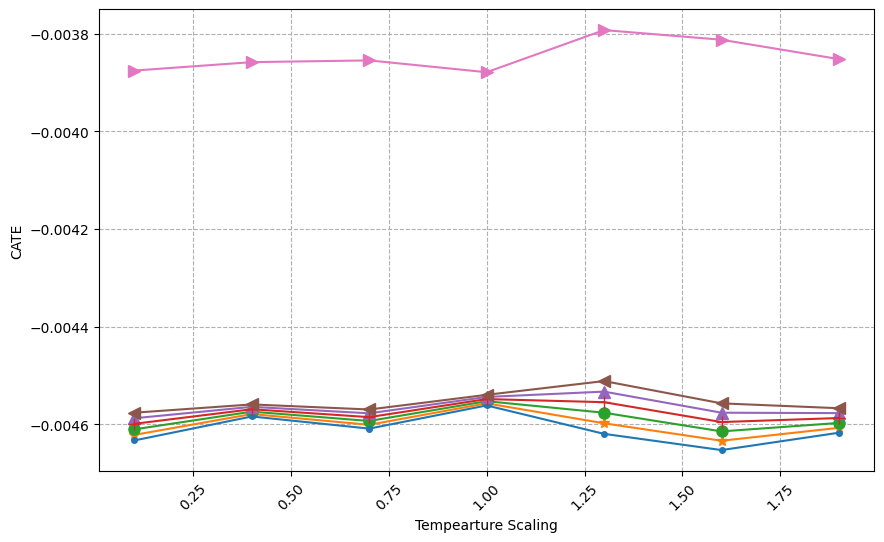

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

reversed_model_map = {value: key for key, value in model_map.items()}
result_df["control_value"] = result_df["control_value"].round(1)
result_df["model_name"] = result_df["model_encoded"].map(reversed_model_map)
grouped = result_df.groupby("model_name")

current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")
output_photo_name = f"SUM_{current_time_str}.svg"
plt.figure(figsize=(10, 6))
i = 0
for name, group in grouped:
    plt.plot(
        group["control_value"],
        group["estimate_value"],
        label=name,
        color=color_map[name],
        marker=marker_map[name],
        markersize=8,
    )
    i += 1
    # plt.fill_between(group['control_value'], group['lower_bound'], group['upper_bound'], alpha=0.01)
plt.grid(
    linestyle="--",
)
plt.xticks(rotation=45)
# plt.legend()

plt.xlabel("Tempearture Scaling")
plt.ylabel("CATE")
plt.savefig(output_photo_path, format="svg", bbox_inches="tight")
# plt.title("Estimate Value vs Control Value for Different Model Encodings")
plt.show()